In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
import matplotlib.pyplot as plt

In [63]:
df = pd.read_excel("./alldata.xlsx")

In [64]:
print(df)

           Date    Price     Open     High      Low   Vol.  Change %  \
0    2010-07-18      0.1      0.0      0.1      0.1   0.08      0.00   
1    2010-07-19      0.1      0.1      0.1      0.1   0.57      0.00   
2    2010-07-20      0.1      0.1      0.1      0.1   0.26      0.00   
3    2010-07-21      0.1      0.1      0.1      0.1   0.58      0.00   
4    2010-07-22      0.1      0.1      0.1      0.1   2.16      0.00   
...         ...      ...      ...      ...      ...    ...       ...   
4932 2024-01-18  41292.7  42763.5  42908.0  40682.6  70.35     -3.45   
4933 2024-01-19  41648.0  41293.8  42164.6  40305.4  72.64      0.86   
4934 2024-01-20  41695.4  41647.6  41858.0  41449.5  22.27      0.11   
4935 2024-01-21  41583.2  41695.4  41878.0  41504.5  16.11     -0.27   
4936 2024-01-22  39556.4  41581.7  41684.9  39468.4  85.05     -4.87   

      FEDFUNDS       Gold  
0         0.18  1204.7500  
1         0.18  1190.2500  
2         0.18  1181.5000  
3         0.18  1191.25

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4937 non-null   datetime64[ns]
 1   Price     4937 non-null   float64       
 2   Open      4937 non-null   float64       
 3   High      4937 non-null   float64       
 4   Low       4937 non-null   float64       
 5   Vol.      4937 non-null   float64       
 6   Change %  4937 non-null   float64       
 7   FEDFUNDS  4937 non-null   float64       
 8   Gold      4937 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 347.3 KB


In [66]:
null_rows = df[df.isnull().any(axis=1)]

# Hiển thị kết quả
print("Các hàng có giá trị null:")
print(null_rows)

Các hàng có giá trị null:
Empty DataFrame
Columns: [Date, Price, Open, High, Low, Vol., Change %, FEDFUNDS, Gold]
Index: []


<Axes: >

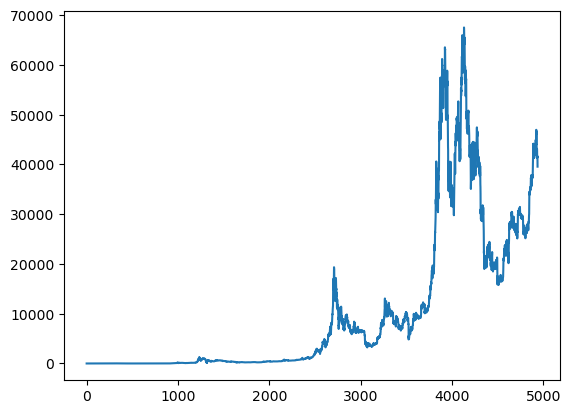

In [67]:
df['Price'].plot()

In [81]:
df_demo = df.iloc[4936:]
df_train = df

print(df_train.shape)

print(df_demo.shape)

(4937, 9)
(1, 9)


In [69]:
output = pd.DataFrame(df_train['Price'])
features = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'FEDFUNDS', 'Gold']

In [70]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df_train[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df_train.index)
print(feature_transform)

          Open      High       Low      Vol.  Change %  FEDFUNDS      Gold
0     0.000000  0.000000  0.000002  0.000080  0.145185  0.024621  0.145612
1     0.000001  0.000000  0.000002  0.000570  0.145185  0.024621  0.132004
2     0.000001  0.000000  0.000002  0.000260  0.145185  0.024621  0.123792
3     0.000001  0.000000  0.000002  0.000580  0.145185  0.024621  0.132942
4     0.000001  0.000000  0.000002  0.002161  0.145185  0.024621  0.128954
...        ...       ...       ...       ...       ...       ...       ...
4902  0.631727  0.630133  0.630780  0.055316  0.142799  1.000000  0.929745
4903  0.625801  0.641807  0.636425  0.070223  0.153610  1.000000  0.921625
4904  0.646544  0.641272  0.652902  0.048983  0.146377  1.000000  0.935067
4905  0.649589  0.643487  0.654547  0.044521  0.145768  1.000000  0.941949
4906  0.651114  0.637689  0.653136  0.021300  0.143687  1.000000  0.941949

[4907 rows x 7 columns]


In [71]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=30)
for train_index, test_index in timesplit.split(feature_transform[features]):
        X_train, X_test = feature_transform[features][:len(train_index)], feature_transform[features][len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output[:len(train_index)].values.ravel(), output[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [72]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [73]:
lstm = Sequential()
lstm.add(LSTM(100, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_absolute_percentage_error', optimizer='adam')
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               43200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 43301 (169.14 KB)
Trainable params: 43301 (169.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=2, verbose=1, shuffle=False)

Epoch 1/100
2375/2375 [==============================] - 6s 2ms/step - loss: 95.9413
Epoch 2/100
2375/2375 [==============================] - 4s 2ms/step - loss: 970.1843
Epoch 3/100
2375/2375 [==============================] - 4s 2ms/step - loss: 192.3737
Epoch 4/100
2375/2375 [==============================] - 4s 2ms/step - loss: 107.1318
Epoch 5/100
2375/2375 [==============================] - 4s 2ms/step - loss: 117.2605
Epoch 6/100
2375/2375 [==============================] - 5s 2ms/step - loss: 97.1385
Epoch 7/100
2375/2375 [==============================] - 4s 2ms/step - loss: 101.2557
Epoch 8/100
2375/2375 [==============================] - 4s 2ms/step - loss: 98.4949
Epoch 9/100
2375/2375 [==============================] - 4s 2ms/step - loss: 119.3896
Epoch 10/100
2375/2375 [==============================] - 4s 2ms/step - loss: 87.3420
Epoch 11/100
2375/2375 [==============================] - 4s 2ms/step - loss: 88.6261
Epoch 12/100
2375/2375 [==============================] -

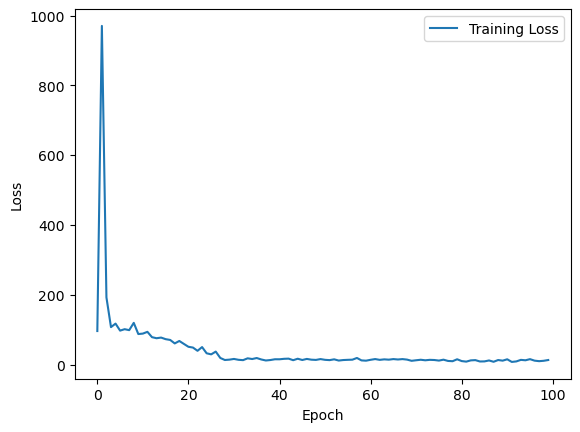

In [75]:
# In biểu đồ sự tiến triển của mô hình
import matplotlib.pyplot as plt
    
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [76]:
y_pred= lstm.predict(X_test)

5/5 [==============================] - 0s 2ms/step


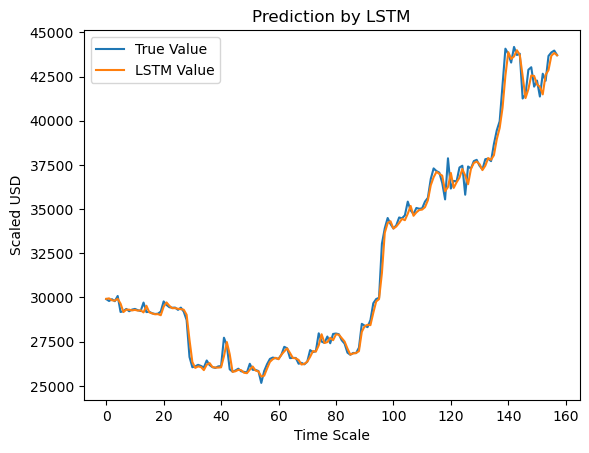

In [77]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [78]:
mape = mean_absolute_percentage_error(y_test,y_pred)
print("MAPE = ", mape)

MAPE =  0.007871841606947596


In [79]:
X_demo = df_demo[['Open', 'High', 'Low', 'Vol.', 'Change %', 'FEDFUNDS', 'Gold']]
y_demo = df_demo['Price']
X_demo = scaler.fit_transform(X_demo)
demoX = np.array(X_demo)
X_demo = demoX.reshape(X_demo.shape[0], 1, X_demo.shape[1])

In [80]:
y_pred_demo = lstm.predict(X_demo)
y_pred_demo

1/1 [==============================] - 0s 27ms/step


array([[28562.81  ],
       [25294.371 ],
       [23491.283 ],
       [20817.201 ],
       [25452.705 ],
       [16857.309 ],
       [13524.635 ],
       [16321.08  ],
       [21784.615 ],
       [41774.668 ],
       [31389.607 ],
       [27320.318 ],
       [31069.104 ],
       [33615.973 ],
       [34535.91  ],
       [41571.324 ],
       [63064.625 ],
       [55666.938 ],
       [66254.19  ],
       [43570.203 ],
       [21907.385 ],
       [18797.777 ],
       [15353.18  ],
       [20365.87  ],
       [22027.771 ],
       [14054.244 ],
       [ 4655.97  ],
       [ 9259.948 ],
       [ 9707.409 ],
       [ 1145.7234]], dtype=float32)